# Introduction to RCMPSP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## `pyjobshop` to describe the RCMPSP

The RCMPSP is a variant of the classical job shop scheduling problem, where each job consists of a set of operations that must be processed in a specific order. The goal is to minimize the makespan, which is the total time required to complete all jobs.
Let's first start by testing the introduction models from the [documentation](https://pyjobshop.readthedocs.io/en/latest/tutorials/intro.html)

At first, it seems like we only need the `Model` from the package which is initialized first empty and then can be filled.

In [11]:
from pyjobshop import Model
from pyjobshop.plot import plot_machine_gantt

In [12]:
model = Model()

Next, we want to add 4 jobs where each job has 2 tasks

In [13]:
# in this case we 
jobs = [model.add_job() for _ in range(4)]
tasks = [[model.add_task(job=job) for _ in range(2)] for job in jobs]

Next, we have to create the machines and also specify processing times for each task. The duration of a task is equal to the job index plus one (1, 2, 3 or 4).

In [14]:
machines = [model.add_machine() for _ in range(2)]

for job in range(len(jobs)):
    for task in tasks[job]:
        for machine in machines:
            duration = job + 1
            model.add_mode(task, machine, duration)

Now that we have defined all important elements, we can now solve this model. By default, the model aims to minimize the makespan, which is the maximum completion time of all jobs.

In [15]:
result = model.solve(display=False)

In [16]:
print(result)

Solution results
  objective: 10.00
lower bound: 10.00
     status: Optimal
    runtime: 0.01 seconds


In [17]:
for task in result.best.tasks:
    print(task)

TaskData(mode=1, resources=[1], start=0, end=1)
TaskData(mode=2, resources=[0], start=0, end=1)
TaskData(mode=5, resources=[1], start=1, end=3)
TaskData(mode=6, resources=[0], start=1, end=3)
TaskData(mode=9, resources=[1], start=3, end=6)
TaskData(mode=10, resources=[0], start=3, end=6)
TaskData(mode=12, resources=[0], start=6, end=10)
TaskData(mode=15, resources=[1], start=6, end=10)


In [8]:
result.best

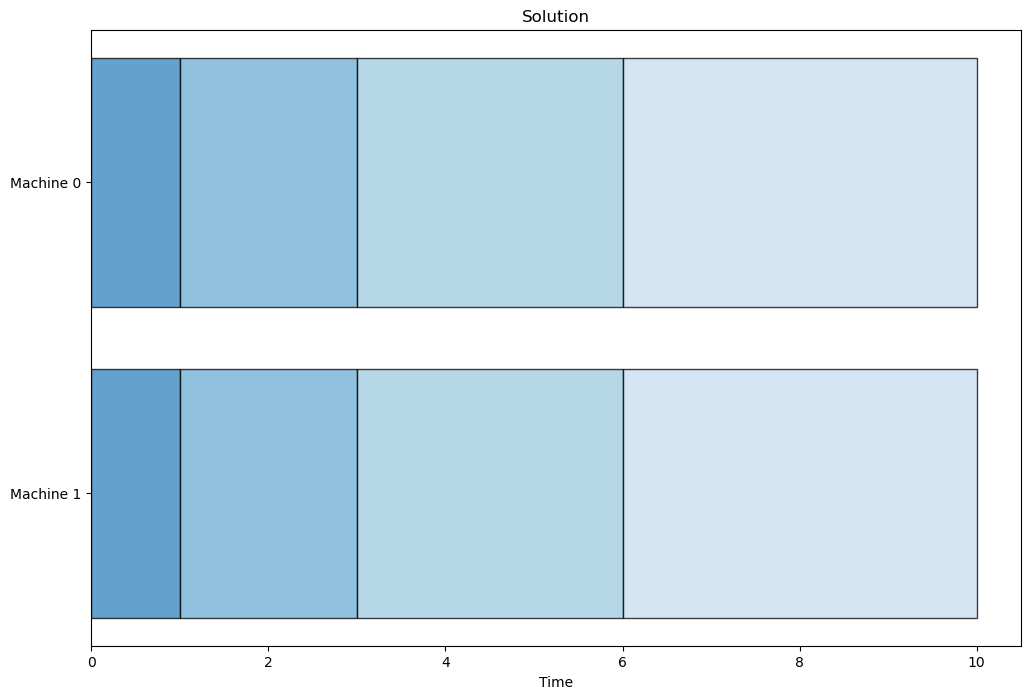

In [9]:
plot_machine_gantt(result.best, model.data())

# Project scheduling example and tutorial

In [18]:
import re
from dataclasses import dataclass
from typing import NamedTuple


class Mode(NamedTuple):
    job: int
    duration: int
    demands: list[int]


@dataclass(frozen=True)
class Instance:
    """
    Problem instance class based on PSPLIB files.

    Code taken from:
    https://alns.readthedocs.io/en/latest/examples/resource_constrained_project_scheduling_problem.html
    """

    num_jobs: int  # jobs in RCPSP are tasks in PyJobshop
    num_resources: int
    successors: list[list[int]]
    predecessors: list[list[int]]
    modes: list[Mode]
    capacities: list[int]
    renewable: list[bool]

    @classmethod
    def read_instance(cls, path: str) -> "Instance":
        """
        Reads an instance of the RCPSP from a file.
        Assumes the data is in the PSPLIB format.
        """
        with open(path) as fh:
            lines = fh.readlines()

        prec_idx = lines.index("PRECEDENCE RELATIONS:\n")
        req_idx = lines.index("REQUESTS/DURATIONS:\n")
        avail_idx = lines.index("RESOURCEAVAILABILITIES:\n")

        successors = []

        for line in lines[prec_idx + 2 : req_idx - 1]:
            _, _, _, _, *jobs, _ = re.split(r"\s+", line)
            successors.append([int(x) - 1 for x in jobs])

        predecessors: list[list[int]] = [[] for _ in range(len(successors))]
        for job in range(len(successors)):
            for succ in successors[job]:
                predecessors[succ].append(job)

        mode_data = [
            re.split(r"\s+", line.strip())
            for line in lines[req_idx + 3 : avail_idx - 1]
        ]

        # Prepend the job index to mode data lines if it is missing.
        for idx in range(len(mode_data)):
            if idx == 0:
                continue

            prev = mode_data[idx - 1]
            curr = mode_data[idx]

            if len(curr) < len(prev):
                curr = prev[:1] + curr
                mode_data[idx] = curr

        modes = []
        for mode in mode_data:
            job_idx, _, duration, *consumption = mode
            demands = list(map(int, consumption))
            modes.append(Mode(int(job_idx) - 1, int(duration), demands))

        _, *avail, _ = re.split(r"\s+", lines[avail_idx + 2])
        capacities = list(map(int, avail))

        renewable = [
            x == "R"
            for x in lines[avail_idx + 1].strip().split(" ")
            if x in ["R", "N"]  # R: renewable, N: non-renewable
        ]

        return Instance(
            int(job_idx),
            len(capacities),
            successors,
            predecessors,
            modes,
            capacities,
            renewable,
        )

In [38]:
from pyjobshop import Model

instance = Instance.read_instance("introduction/data/j90/j9041_6.sm")
model = Model()

In [22]:
model = Model()

# It's not necessary to define jobs, but it will add coloring to the plot.
jobs = [model.add_job() for _ in range(instance.num_jobs)]
tasks = [model.add_task(job=jobs[idx]) for idx in range(instance.num_jobs)]
resources = [model.add_renewable(capacity) for capacity in instance.capacities]

In [23]:
for idx, duration, demands in instance.modes:
    model.add_mode(tasks[idx], resources, duration, demands)

In [24]:
for idx in range(instance.num_jobs):
    task = tasks[idx]

    for pred in instance.predecessors[idx]:
        model.add_end_before_start(tasks[pred], task)

    for succ in instance.successors[idx]:
        model.add_end_before_start(task, tasks[succ])

In [25]:
result = model.solve(time_limit=5, display=False)
print(result)

Solution results
  objective: 140.00
lower bound: 121.00
     status: Feasible
    runtime: 5.02 seconds


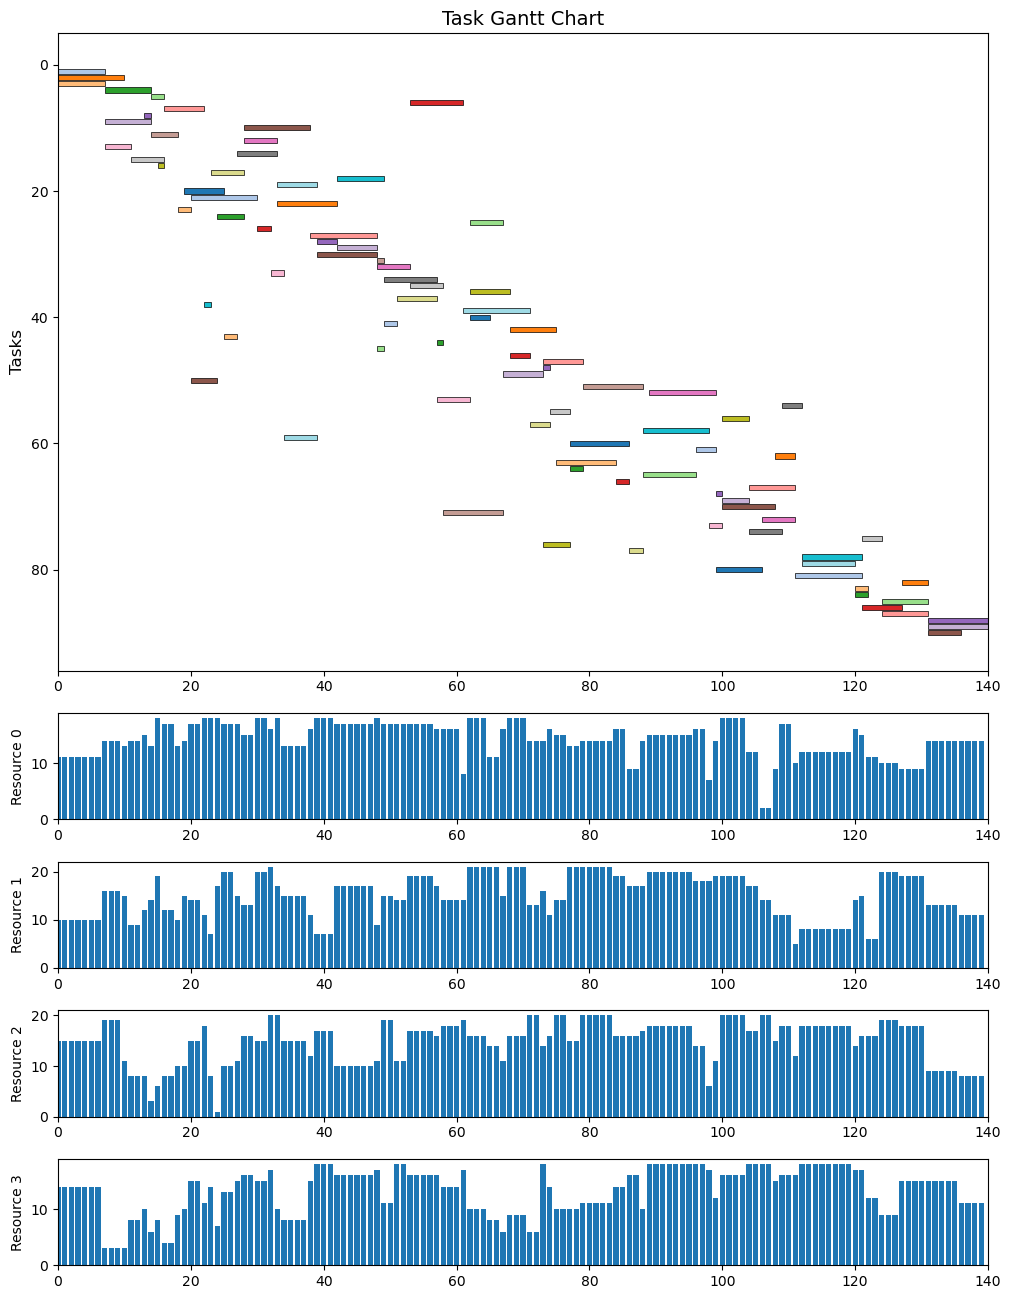

In [26]:
import matplotlib.pyplot as plt

from pyjobshop.plot import plot_resource_usage, plot_task_gantt

data = model.data()
fig, axes = plt.subplots(
    data.num_resources + 1,
    figsize=(12, 16),
    gridspec_kw={"height_ratios": [6] + [1] * data.num_resources},
)

plot_task_gantt(result.best, model.data(), ax=axes[0])
plot_resource_usage(result.best, model.data(), axes=axes[1:])

In [ ]:
''' # --- Indices (Implicit in Set/Param/Var definitions) ---
# p: Project (Often handled implicitly by defining which activities belong to which project)
# j: Activity
# m: Mode
# a: Production area
# w: Pool of workers
# t: Planning period

# --- Sets ---
# Assuming 'model' is an object from an optimization library (e.g., Pyomo)
# Replace 'initialize=[...]' with your actual data loading mechanism

# Set of activities
model.J = Set() # e.g., initialize=['Act1', 'Act2', ...] or range(num_activities)

# Set of finish activities (subset of J)
model.J_F = Set(within=model.J) # e.g., initialize=['ActN', ...]

# Set of modes
model.M = Set() # e.g., initialize=['ModeA', 'ModeB', ...] or range(num_modes)

# Set of activities executable in mode m (Indexed Set)
# Option 1: Dictionary mapping mode to set of activities
# activities_by_mode = {'ModeA': {'Act1', 'Act2'}, 'ModeB': {'Act1', 'Act3'}}
# Option 2: Pyomo Indexed Set
model.J_m = Set(model.M) # e.g., initialize={'ModeA': ['Act1', 'Act2'], ...}

# Set of modes for activity j (Indexed Set)
# Option 1: Dictionary mapping activity to set of modes
# modes_by_activity = {'Act1': {'ModeA', 'ModeB'}, 'Act2': {'ModeA'}}
# Option 2: Pyomo Indexed Set
model.M_j = Set(model.J) # e.g., initialize={'Act1': ['ModeA', 'ModeB'], ...}

# Set of production areas
model.A = Set() # e.g., initialize=['Area1', 'Area2', ...]

# Set of precedence relations (set of pairs (j, k))
model.E = Set(dimen=2) # e.g., initialize=[('Act1', 'Act2'), ('Act1', 'Act3'), ...]

# Set of pools of workers
model.W = Set() # e.g., initialize=['PoolX', 'PoolY', ...]

# Set of planning periods
# Often represented as a range or specific time points
model.T = Set() # e.g., initialize=range(T_max) or specific dates/times

# --- Parameters ---

# Processing time of activity j in mode m
model.p = Param(model.J, model.M) # e.g., initialize={(j, m): time_value, ...}

# Weight for finish activities j
model.alpha = Param(model.J_F) # e.g., initialize={j: weight_value, ...}

# Penalty for earliness (scalar)
model.beta_e = Param() # e.g., initialize=value

# Penalty for tardiness (scalar)
model.beta_t = Param() # e.g., initialize=value

# Due date of finish activity j
model.d = Param(model.J_F) # e.g., initialize={j: date_value, ...}

# Resource requirement of activity j for pool w in mode m
model.r = Param(model.J, model.W, model.M) # e.g., initialize={(j, w, m): req_value, ...}

# Lower bound for allocation of pool w in area a
model.q_lower = Param(model.W, model.A) # e.g., initialize={(w, a): lower_bound, ...}

# Upper bound for allocation of pool w in area a
model.q_upper = Param(model.W, model.A) # e.g., initialize={(w, a): upper_bound, ...}

# Capacity of worker pool w at time t
model.b = Param(model.W, model.T) # e.g., initialize={(w, t): capacity_value, ...}

# Earliest start time of activity j
model.ES = Param(model.J) # e.g., initialize={j: time_value, ...}

# Latest finish time of activity j
model.LF = Param(model.J) # e.g., initialize={j: time_value, ...}

# Transfer time if activity (successor) is in mode n while predecessor was in mode m
# Assumes indices are (mode_predecessor, mode_successor)
model.delta = Param(model.M, model.M) # e.g., initialize={(m, n): transfer_time, ...}

# Planning horizon (scalar, potentially used to define Set T)
model.T_max = Param() # e.g., initialize=value

# --- Continuous Variables ---

# Earliness of activity j (likely for j in J_F)
# Assuming non-negative
model.earliness = Var(model.J_F, domain=NonNegativeReals) # Using J_F based on context of alpha and d

# Tardiness of activity j (likely for j in J_F)
# Note: The image uses t_j, which conflicts with t as the time index. Renamed for clarity.
# Assuming non-negative
model.tardiness = Var(model.J_F, domain=NonNegativeReals) # Using J_F based on context of alpha and d

# Capacity of worker pool w allocated to production area a in period t
# Assuming non-negative
model.q_allocated = Var(model.A, model.W, model.T, domain=NonNegativeReals)

# --- Binary Variables ---

# x[j,m,t] = 1 if activity j starts in mode m at the beginning of period t or before, 0 otherwise
# Note: The definition "or before" makes this a cumulative or step variable, not a simple start indicator.
model.x = Var(model.J, model.M, model.T, domain=Binary)

'''

NameError: name 'Set' is not defined